In [1]:
!git clone https://rilianx@github.com/rilianx/CPMP-ML.git

Cloning into 'CPMP-ML'...
remote: Enumerating objects: 1827, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 1827 (delta 101), reused 230 (delta 89), pack-reused 1581
Receiving objects: 100% (1827/1827), 6.69 MiB | 10.24 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [2]:
%cd CPMP-ML

/content/CPMP-ML


##Librerias Necesarias

In [3]:
import numpy as np
import keras
from keras.layers import Input, Add, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D, InputLayer, Flatten
from keras.models import Model
from keras.utils import to_categorical
import cpmp_ml
import numpy as np
from cpmp_ml import generate_random_layout, generate_data, get_move
import random
import tensorflow as tf
from copy import deepcopy
import time

In [4]:
#@title Funciones necesarias

def is_valid_BG_move(layout, s_o, s_d):
    if (s_o != s_d  and len(layout.stacks[s_o]) > 0
    and  len(layout.stacks[s_d]) < layout.H
    and layout.is_sorted_stack(s_o)==False
    and layout.is_sorted_stack(s_d)==True
    and layout.gvalue(s_o) <= layout.gvalue(s_d)):
      return True

    else: return False

In [5]:
def select_bg_move(layout):
  bg_move = None
  S=len(layout.stacks)
  min_diff = 100
  for s_o in range(S):
     for s_d in range(S):
       if is_valid_BG_move(layout, s_o, s_d):
          diff = layout.gvalue(s_d) - layout.gvalue(s_o)
          if min_diff > diff:
            min_diff = diff
            bg_move = (s_o,s_d)
  return bg_move

In [6]:
def greedy(layout, basic=True):
    moves = []
    steps = 0
    while layout.unsorted_stacks>0:
        bg_move=select_bg_move(layout)
        if bg_move is not None:
            moves.append(bg_move)
            layout.move(bg_move)
        else:
            return -1, None # no lo resuelve
        steps +=1

    if layout.unsorted_stacks==0:
        return steps, moves
    return -1, None

In [7]:
def unlist(data,labels1, labels2, state, source, destination):
  n = len(source)
  for i in range(n):
    data.append(state[i])
    labels1.append(source[i])
    labels2.append(destination[i])

In [8]:
def get_ann_state(layout):
  S=len(layout.stacks)
  #matriz de stacks
  b = 2. * np.ones([S,layout.H + 1])
  for i,j in enumerate(layout.stacks):
     b[i][layout.H-len(j) + 1:] = [k/layout.total_elements for k in j]
     b[i][0] = layout.is_sorted_stack(i)
  b.shape=(S,(layout.H + 1))
  return b

#overriding the function in the module
cpmp_ml.get_ann_state = get_ann_state

In [9]:
def convert_label(score):
    list_score = []

    for i in score:
        list_score.append(i)

    return np.array(list_score)

In [10]:
def generate_steps_of_a_state(layout):
    states = [] # estados antes de movimiento
    source_tags = [] # etiquetas origen
    destination_tags = []  # etiquetas destino

    aux = deepcopy(layout)  # creación de copia de objeto

    steps, moves = greedy(aux)
    if steps == -1:
      return None, None, None

    for i in range(steps):
        states.append(get_ann_state(layout)) # antes del movimiento
        source_tags.append(convert_label(to_categorical(moves[i][0],len(layout.stacks))))
        destination_tags.append(convert_label(to_categorical(moves[i][1],len(layout.stacks))))
        layout.move(moves[i])
        aux = deepcopy(layout)

    return states, source_tags, destination_tags

In [11]:
def create_different_states(S, H, max_priority_container, n):
  data_state = []
  labels_source = []
  labels_destination = []
  iter = 0
  while iter < n:
    layout = generate_random_layout(S,H,max_priority_container)
    state, source, destination = generate_steps_of_a_state(layout)
    if state == None and source == None and destination == None: continue
    unlist(data_state,labels_source,labels_destination,state,source,destination)
    iter+=1

  return data_state, labels_source, labels_destination

In [12]:
#@markdown Este método toma un estado, vectores de N x d_stack y se asegura que tengan entradas similares con sus labels correspondientes. Además entrena el modelo según el estado entregado de manera itereativa, asi se evitan problemas que surgian en el entrenamiento tradicional.
#@markdown Se debe asegurar que la entrada sea una lista de matrices.
def controlled_training(model, matrix_list, labels_list, d_stack, epochs):
  for epoch in range(1,epochs+1):
    l = zip(matrix_list, labels_list)

    for matrix, labels in l:
      reshape =np.reshape(matrix, (matrix.shape[0],d_stack))
      loss = model.train_on_batch(reshape,labels)
      print(f'Epoch: {epoch} / {epochs}, Loss: {loss[0]}')

In [13]:
def iter_predict(model,x):
  predict = []
  for i in x:
    predict.append(model.predict(i))
  return predict

In [14]:
def compare(predict, y_test):
    aciertos = 0
    size = len(predict)

    for i in range(size):
        max_1 = np.argmax(predict[i])
        max_2 = np.argmax(y_test[i])

        if max_1 == max_2:
            aciertos += 1

    return aciertos / size

In [15]:
def concatenate_state_with_output(states, outputs):
    xd = zip(states, outputs)

    for state, output in xd:
        i = 0
        for stacks in state:
            stacks.append(output[i])
            i += 1

In [16]:
#@title Modelo de atención y clasificador de stacks

# Capa de normalización de datos
def normalization_layer(input, attention):
    layer = Add()([input,attention])
    layer = LayerNormalization(epsilon=1e-6)(layer)
    return layer

In [17]:
# Capa de feed-fordward, en el fondo es la parte entrenable
# que ayuda al modelo a darle caracteristicas a las entradas
def feed_forward_layer(input, num_neuron):
    # capa de feed para que el modelo pueda aprender
    layer = Dense(num_neuron,activation='sigmoid')(input)
    layer = Dense(num_neuron)(layer)
    return layer

In [18]:
# capa de atencion, al principio se probará con un cabezal,
# que corresponde calcular un scaled-dot-product-attention
def attention_layer(heads, d_model, reshape):
    attention = MultiHeadAttention(num_heads=heads, key_dim=d_model)(reshape,reshape)
    return attention

In [19]:
# Creacion de modelo de clasificación binaria con softmax
def stack_attention(heads, d_model, reshape, input):
  # por si se debe modificar la dimensión
  attention = attention_layer(heads,d_model,reshape)
  normalization = normalization_layer(input, attention)
  feed = feed_forward_layer(normalization, d_model)

  return feed

In [29]:
def create_model(heads, S, H , optimizer):
  input = Input(shape= (S, H+1))
  #reshape = tf.expand_dims(input,axis=1)

  reshape = stack_attention(heads, H + 1, input, input)
  reshape = stack_attention(heads, H + 1, reshape, input)

  #reshape = tf.squeeze(reshape,axis=1)
  reshape = Flatten()(reshape)
  hidden1 = Dense(H*6, activation='sigmoid')(reshape)
  hidden2 = Dropout(0.5)(hidden1)
  hidden3 = Dense(H*6, activation='sigmoid')(hidden2)
  output = Dense(S,activation='softmax')(hidden3)

  model = Model(inputs=input,outputs=output)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['mae', 'mse', 'accuracy'])
  return model

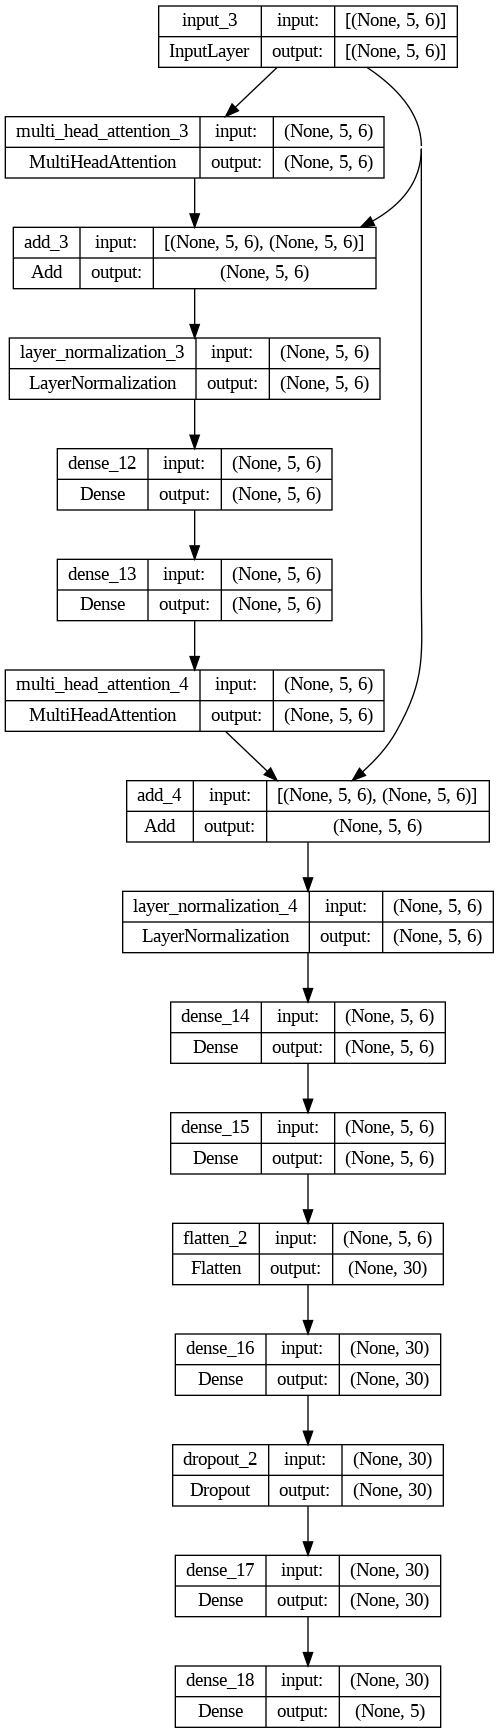

In [70]:
#@title Diagrama del modelo
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin = create_model(5, 5, 5, optimizer)
keras.utils.plot_model(model_cpmp_origin,show_shapes=True)

In [71]:
model_cpmp_origin.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 6)]       0           []                               
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 5, 6)        816         ['input_3[0][0]',                
 eadAttention)                                                    'input_3[0][0]']                
                                                                                                  
 add_3 (Add)                    (None, 5, 6)         0           ['input_3[0][0]',                
                                                                  'multi_head_attention_3[0][0]'] 
                                                                                            

In [32]:
#@title Generador de data

# Cantidad de stacks
S = 7 #@param {type:'slider',min:1,max:1000,steps:1}

# Altura de la bahía
H = 7#@param {type:'slider',min:1,max:1000,steps:1}

# Número máximo de prioridad
MPC = 28 #@param {type:'slider',min:1,max:1000,steps:1}

# Cantida casos de entrenamiento
N = 2000 #@param {type:'slider',min:1,max:100000,steps:1}

X_train, y_train_1, y_train_2 = create_different_states(S, H, MPC, N)

KeyboardInterrupt: ignored

In [33]:
len(X_train)

30188

In [76]:
# Cantidad de stacks
S2 = 5 #@param {type:'slider',min:1,max:100,steps:1}

# Altura de la bahía
H2 = 5 #@param {type:'slider',min:1,max:100,steps:1}

# Número máximo de prioridad
MPC2 = 15 #@param {type:'slider',min:1,max:100,steps:1}

# Cantida casos de prueba
N2 = 8250 #@param {type:'slider',min:1,max:10000,steps:1}

X_test, y_test_1, y_test_2 = create_different_states(S2, H2, MPC2, N2)

In [74]:
X_train = np.stack(X_test)
y_train_1 = np.stack(y_test_1)

In [75]:
model_cpmp_origin.fit(X_train, y_train_1, epochs= 75, batch_size= 32)

Epoch 1/75
1549/1549 [==============================] - 16s 9ms/step - loss: 1.0038 - mae: 0.2199 - mse: 0.1036 - accuracy: 0.6015
Epoch 2/75
1549/1549 [==============================] - 13s 9ms/step - loss: 0.6367 - mae: 0.1471 - mse: 0.0713 - accuracy: 0.7360
Epoch 3/75
1549/1549 [==============================] - 14s 9ms/step - loss: 0.5788 - mae: 0.1358 - mse: 0.0663 - accuracy: 0.7515
Epoch 4/75
1549/1549 [==============================] - 13s 8ms/step - loss: 0.5494 - mae: 0.1303 - mse: 0.0639 - accuracy: 0.7618
Epoch 5/75
1549/1549 [==============================] - 13s 8ms/step - loss: 0.5305 - mae: 0.1269 - mse: 0.0624 - accuracy: 0.7664
Epoch 6/75
1549/1549 [==============================] - 13s 9ms/step - loss: 0.5092 - mae: 0.1230 - mse: 0.0605 - accuracy: 0.7742
Epoch 7/75
1549/1549 [==============================] - 13s 8ms/step - loss: 0.4884 - mae: 0.1187 - mse: 0.0585 - accuracy: 0.7765
Epoch 8/75
1549/1549 [==============================] - 13s 9ms/step - loss: 0.4728

In [77]:
X_test = np.stack(X_test)

In [78]:
len(X_test)

49583

In [79]:
predict = model_cpmp_origin.predict(X_test)

1550/1550 [==============================] - 7s 4ms/step


In [80]:
result = compare(predict, y_test_1)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 95.7%
